## Lecture 33: Intro to Optimization

Goal: to motivate the use of an optimization framework, based on an imaging example.

In [14]:
## MP 573 Lecture 33: Intro to optimization
##
%matplotlib inline
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
from IPython.display import display, Image
import matplotlib.image as mpimg
from os.path import dirname, join as pjoin
import scipy.io as sio
np.set_printoptions(precision=2)

# Example: A tiny imaging system

Let's consider an image reconstruction problem where we have a tiny image with just two pixels (with unknown signal intensities $x_0$ and $x_1$, respectively). Our imaging system produces three measurements consisting of different linear combinations of the pixel values: 
$$y_0 = x_0 + x_1$$
$$y_1 = x_0 - x_1$$
$$y_2 = x_0 + 2 x_2$$
In other words, $\mathbf{y} = \mathbf{A x}$ for $$\mathbf{A} = \left( \begin{array}{ccc}1 & 1 \\ 1 &-1 \\ 1 & 2 \end{array}  \right)$$
Note that this is an overdetermined system, so in principle we could ignore one of the three measurements. However, our measurements actually contain noise, so in reality our measurements are given by $d_m = y_m + \eta_m$, for $m=0,1,2$, where $\eta_m$ represents an independent noise process (say, zero-mean Gaussian noise). In other words: $$\mathbf{d} = \mathbf{A x} + \mathbf{\eta}$$
 


In [48]:
# Simulate some true image
x = np.zeros(2)
x[0] = 0.5
x[1] = 1.0

# Noiseless samples
M = 3
A = [[1,1], 
    [1,-1],
    [1,2]]
y = np.zeros(M)
y[0] = A[0][0]*x[0] + A[0][1]*x[1]
y[1] = A[1][0]*x[0] + A[1][1]*x[1]
y[2] = A[2][0]*x[0] + A[2][1]*x[1]

# Noisy samples
NoiseStd = 0.0 # Set to zero for noiseless
d = y + rnd.normal(0, NoiseStd, M)
print(" True image x = " , x )
print(" Noiseless data vector y = " , y )
print(" Noisy data vector d =     " , d )

 True image x =  [0.5 1. ]
 Noiseless data vector y =  [ 1.5 -0.5  2.5]
 Noisy data vector d =      [ 1.5 -0.5  2.5]


# Image reconstruction 

Now let's recover our image. Note that: 
1. We have more measurements than pixels (overdetermined system)
2. If the measurements are noisy, there is generally not a single image we can recover that perfectly fits our data. 

So we will need to *decide* which image $(x_0,x_1)$ is the best given our data. 


Potential images given our data: d =  [ 1.5 -0.5  2.5]
And trying to force: d = Ax 
We can visualize each data point as a line in the space (x0,x1) of potential images


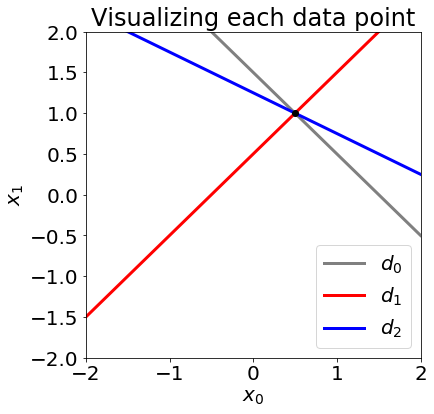

In [49]:
# Let's consider the space of possible images, ie: the 2D space (x0,x1)
N = 501
xmax = 2
x0 = np.linspace(-xmax,xmax,N)

# Let's plot the possible images suggested by the data (if noiseless)
x1_0 = (d[0] - A[0][0]*x0)/A[0][1]
x1_1 = (d[1] - A[1][0]*x0)/A[1][1]
x1_2 = (d[2] - A[2][0]*x0)/A[2][1]


# Let's plot these data "constraints"
plt.figure(figsize=(6,6))
font = {'weight' : 'normal',
        'size'   : 20}
plt.rc('font', **font)
h0 = plt.plot(x0,x1_0,'gray',linewidth=3.0)
h1 = plt.plot(x0,x1_1,'red',linewidth=3.0)
h2 = plt.plot(x0,x1_2,'blue',linewidth=3.0)
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
plt.title('Visualizing each data point')
plt.axis([-xmax, xmax, -xmax, xmax])
plt.legend( ('$d_0$','$d_1$','$d_2$'));
plt.plot(x[0],x[1],'ok',markersize=6)

#plt.tight_layout(pad=4.0)
print("Potential images given our data: d = ", d)
print("And trying to force: d = Ax ")
print("We can visualize each data point as a line in the space (x0,x1) of potential images")



# Image reconstruction as an optimization problem

Instead, a common formulation of the image reconstruction problem is a least-squares formulation, where we seek the image that best fits the data in the least-squares sense: 

$$\hat{\mathbf{x}} = \arg \min_{\mathbf{x}} \| \mathbf{d} - \mathbf{A x} \|_2^2$$

where 

$$\| \mathbf{d} - \mathbf{A x} \|_2^2 = \sum_m |d_m - [\mathbf{A x}]_m |^2$$

is simply the sum of squares of data fit errors. 

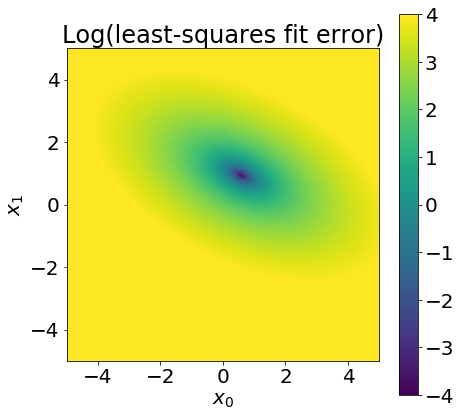

In [32]:
# Let's consider the space of possible images, ie: the 2D space (x0,x1)
N = 501
xmax = 5
xval = np.linspace(-xmax,xmax,N)
X0, X1 = np.meshgrid(xval,-xval)

# Here's our cost function
f = (A[0][0]*X0 + A[0][1]*X1 - d[0])**2 + (A[1][0]*X0 + A[1][1]*X1 - d[1])**2 + (A[2][0]*X0 + A[2][1]*X1 - d[2])**2;

# Display the cost function
plt.figure(figsize=(7,7))
imgplot = plt.imshow(np.log(f),extent = [xval[0], xval[N-1], xval[0], xval[N-1]],vmin=-4, vmax=4)
#plt.title('Log($\|\| \mathbf{d} - \mathbf{A x} \| \|_2^2$)')
plt.title('Log(least-squares fit error)')
plt.xlabel('$x_0$')
plt.ylabel('$x_1$');
font = {'weight' : 'normal',
        'size'   : 20}
plt.rc('font', **font)
plt.colorbar();

In [31]:
# Find the optimal solution over our discretized array
imin = np.argmin(f)
x0ind,x1ind = np.unravel_index(imin, f.shape)
xhat = np.zeros(2)
xhat[0] = X0[x0ind,x1ind]
xhat[1] = X1[x0ind,x1ind]
print("Optimal solution for image reconstruction: xhat0 = ", f"{xhat[0]:.3}" , ", xhat1: ", f"{xhat[1]:.3}")
print("Remember the true image pixels were: x0 = ", f"{x[0]:.3}" , ", x1: ", f"{x[1]:.3}")

Optimal solution for image reconstruction: xhat0 =  0.56 , xhat1:  0.94
Remember the true image pixels were: x0 =  0.5 , x1:  1.0


# But, what if we have further prior information about our image? 

For instance, we may know that our images tend to be spatially smooth, or sparse, etc. We will discuss this in more detail over the next few weeks. 